# Import libraries

In [77]:
# import standard libraires
# import third-part libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_regression, RFECV, RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
# import local libraries

# Import data

In [2]:
# import data ready from eda
data = pd.read_csv('movies_metadata_eda.csv')

In [3]:
data

,adult,budget,popularity,revenue,runtime,video,vote_average,vote_count,release_year,release_month,...,production_countries_num,North America,South America,Asia,Australia,Africa,Europe,spoken_languages_num,spoken_languages_weight,belongs_to_collection
0,0,30000000.0,21.946943,373554033.0,81.0,0,7.7,5415.0,1995,10,...,1,1,0,0,0,0,0,1,0.544100,1
1,0,65000000.0,17.015539,262797249.0,104.0,0,6.9,2413.0,1995,12,...,1,1,0,0,0,0,0,2,0.623221,0
2,0,0.0,11.712900,0.0,101.0,0,6.5,92.0,1995,12,...,1,1,0,0,0,0,0,1,0.544100,1
3,0,16000000.0,3.859495,81452156.0,127.0,0,6.1,34.0,1995,12,...,1,1,0,0,0,0,0,1,0.544100,0
4,0,60000000.0,17.924927,187436818.0,170.0,0,7.7,1886.0,1995,12,...,1,1,0,0,0,0,0,2,0.589291,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42659,0,0.0,5.683753,0.0,104.0,0,5.7,26.0,1991,5,...,4,1,0,0,0,0,1,1,0.544100,0
42660,0,0.0,0.178241,0.0,360.0,0,9.0,3.0,2011,11,...,1,0,0,1,0,0,0,0,0.000000,0
42661,0,0.0,0.903007,0.0,90.0,0,3.8,6.0,2003,8,...,1,1,0,0,0,0,0,1,0.544100,0
42662,0,0.0,0.003503,0.0,87.0,0,0.0,0.0,1917,10,...,1,0,0,0,0,0,1,0,0.000000,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42664 entries, 0 to 42663
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   adult                        42664 non-null  int64  
 1   budget                       42664 non-null  float64
 2   popularity                   42664 non-null  float64
 3   revenue                      42664 non-null  float64
 4   runtime                      42664 non-null  float64
 5   video                        42664 non-null  int64  
 6   vote_average                 42664 non-null  float64
 7   vote_count                   42664 non-null  float64
 8   release_year                 42664 non-null  int64  
 9   release_month                42664 non-null  int64  
 10  roi                          42664 non-null  float64
 11  revenue_norm_max             42664 non-null  float64
 12  year_revenue_max             42664 non-null  float64
 13  budget_norm_max 

# Feature selection

In [5]:
# separate exo and indogeneous variables, We choose to predict revenue_norm_mean
# this means we need to drop all columns that contain the revenue 
data = pd.read_csv('movies_metadata_eda.csv')
data = data.astype(np.float64)
target_label = 'revenue_norm_mean'
data = data.drop(columns = ['revenue', 'roi', 'revenue_norm_max'])
X, y = data.drop(columns = target_label), data[[target_label]]
y = y[target_label]

# normalize inputs
X_trans = MinMaxScaler().fit_transform(X)
X_trans = pd.DataFrame(data = X_trans, columns = X.columns, index = X.index)

# keep a eye on number of accepted features
feature_score = pd.DataFrame(index = X.columns)

## Pearson correlation

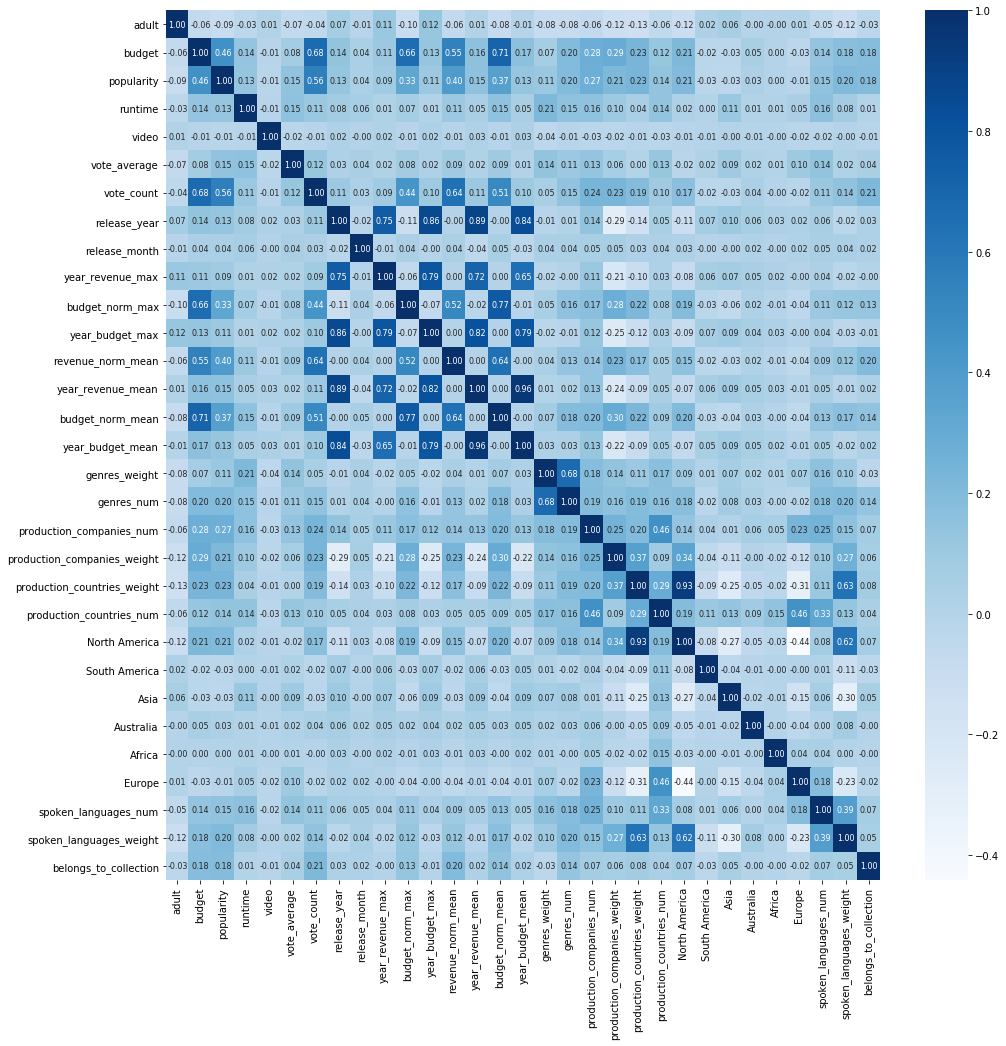

In [6]:
# since all columns are numeric, we can compute the pearsoncorrelation 
fig, ax = plt.subplots(figsize = (16, 16))
pearson = data.corr()
sns.heatmap(pearson, annot = True, cmap = plt.cm.Blues, annot_kws = {'size': 8}, fmt = '.2f')

If we look under revenue_norm_mean, we see that the following columns have a pearson correlation above apprimately 0.20: budget, popularity, vote_count, budget_norm_max, budget_norm_mean, production_companies_weight, belongs_to_collection. A total of 7 features could be selected.

In [7]:
feature_score['pearson'] = np.nan
feature_score['pearson'] = pearson[target_label].apply(lambda x: True if x > 0.19 else False)
num_feat = feature_score['pearson'].sum()
num_feat

7

## F-value selection

In [8]:
kbest_selector = SelectKBest(score_func = f_regression, k = num_feat)
kbest_selector = kbest_selector.fit(X_trans, y)
kbest = kbest_selector.get_support()
# add to feature_score
feature_score['f_value'] = np.nan
feature_score['f_value'] = kbest

## RFE selection

In [9]:
temp_est = SVR(kernel = 'linear')
rfe = RFE(temp_est, n_features_to_select = 7, step = 1)
rfe = rfe.fit(X_trans, y)
rfe_best = rfe.get_support()

In [12]:
feature_score['rfe'] = np.nan
feature_score['rfe'] = rfe_best

In [15]:
feature_score['total_score'] = feature_score[['pearson', 'f_value', 'rfe']].sum(axis = 1)
feature_score

,pearson,f_value,rfe,total_score
adult,False,False,False,0
budget,True,True,True,3
popularity,True,True,True,3
runtime,False,False,False,0
video,False,False,False,0
vote_average,False,False,False,0
vote_count,True,True,True,3
release_year,False,False,False,0
release_month,False,False,False,0
year_revenue_max,False,False,False,0


## Best features

In [18]:
best_feature = feature_score.sort_values(by = 'total_score', ascending = False)[:num_feat]
best_feature

,pearson,f_value,rfe,total_score
production_companies_weight,True,True,True,3
popularity,True,True,True,3
budget,True,True,True,3
budget_norm_mean,True,True,True,3
budget_norm_max,True,True,True,3
vote_count,True,True,True,3
belongs_to_collection,True,True,False,2


## Filter X of best features

In [26]:
X_trans_best = X_trans[best_feature.index.values]
X_trans_best

In [29]:
X_trans_best.to_csv('movies_metadata_eda_x_trans_best.csv', index = False)

# SVR with CV

In [32]:
X_trans_best = pd.read_csv('movies_metadata_eda_x_trans_best.csv')

In [52]:
# seperate x data into training and test sets, we take 30% test and 70% train
X_train, X_test, y_train, y_test = train_test_split(X_trans_best, y, test_size = 0.3)

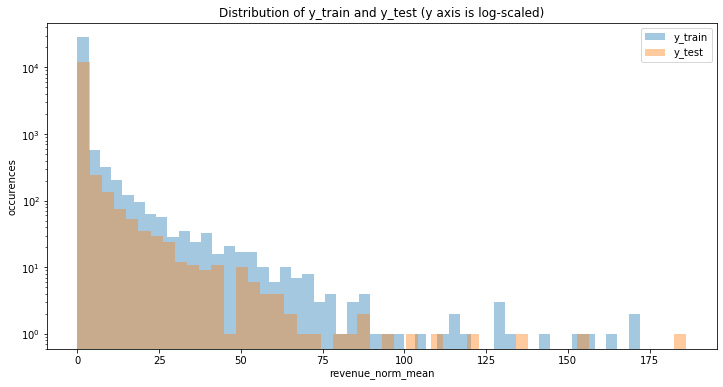

In [60]:
# check if y_train and y_test are equally distributed
fig, ax = plt.subplots(figsize = (12, 6))
g = sns.distplot(y_train, kde = False, ax = ax, label = 'y_train')
g.set_yscale('log')
sns.distplot(y_test, kde = False, ax = ax, label = 'y_test')
g.set_ylabel('occurences')
g.set_title('Distribution of y_train and y_test (y axis is log-scaled)')
g.legend()

In [75]:
# define grid of hyperparameters for SVR
param_grid = {'C': [1, 10, 100, 1000], 
              'gamma': [0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'linear']}
scores = ['r2', 'neg_mean_absolute_error']
regressors = {k: None for k in scores}
results = {k: None for k in scores}

In [ ]:
# perform grid search for all score
for s in scores:
    # create grid search for hyperparameters
    reg = GridSearchCV(SVR(), param_grid, scoring = s) # we use default 5-fold cross validation
    # fit
    reg.fit(X_train, y_train)
    # keep fitted regressor
    regressors[s] = reg
    # get score and parameters and create a dataframe of results
    means = reg.cv_results_['mean_test_score']
    params = reg.cv_results_['params']
    break
        